# Import

In [18]:
import pickle

# math and dataframes
import pandas as pd
import numpy as np
import scipy as sp

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier
import tensorflow as tf

# Pipeline and Evaluation
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.tree import plot_tree
from imblearn.pipeline import make_pipeline

# Undersampling 
# Note: undersampling was used in at least 1 paper predicting popularity (Gao 2021)
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# jupyter notebook full-width display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# pandas formatting
pd.set_option('display.float_format', '{:.3f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

# plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import seaborn as sns
sns.set_theme()

In [2]:
df_10M = pd.read_pickle('df_10M_clustered.pickle')
X_all = pd.read_pickle('X_clustered.pickle')

# Create Datasets for Prediction

In [3]:
y_column = 'in_B100'
X_columns = [
    'mode', 'acousticness', 'danceability', 'duration_ms', 'energy',
    'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'valence'
]
genre_columns = [
    'is_Adult_Standard', 'is_Rock', 'is_R&B', 'is_Country', 'is_Pop',
    'is_Rap', 'is_Alternative', 'is_EDM', 'is_Metal'
]
cluster_columns = ['cluster', 'cluster2']
other_columns = ['key', 'time_signature', 'genre', 'release_date']


In [94]:
# create a dict with all 'name': (X, y) key match pairs
clusters = {}

# entire predictive dataset
clusters['All'] = (X_all[X_columns+genre_columns], X_all[y_column])
# clusters['All'] = (X_all[X_columns], X_all[y_column])

# add genres
for genre in genre_columns:
    title = genre[3:]
    clusters[title] = (X_all[X_all[genre]][X_columns], X_all[X_all[genre]][y_column])
    
# add clusters
for n in sorted(X_all['cluster'].unique()):
    title = genre[3:]
    clusters['cluster1_' + str(n)] = (X_all[X_all['cluster'] == n][X_columns], X_all[X_all['cluster'] == n][y_column])
    
for n in sorted(X_all['cluster2'].unique()):
    title = genre[3:]
    clusters['cluster2_' + str(n)] = (X_all[X_all['cluster2'] == n][X_columns], X_all[X_all['cluster2'] == n][y_column])
    
# setup tuning algorithm with a small dataset
small = X_all.sample(10_000, random_state=42)
X_small = small[X_columns]
y_small = small[y_column]
clusters['small'] = (X_small, y_small)
    
# OPTIONAL IF TIME PERMITS: consider adding decades or eras of music

# Tune Algorithms

In [95]:
cluster_keys = [
    'All', 
    'Adult_Standard', 'Rock', 'R&B', 'Country', 'Pop', 'Rap', 'Alternative', 'EDM', 'Metal', 
    'cluster1_0', 'cluster1_1', 'cluster1_2', 'cluster1_3', 
    'cluster2_0', 'cluster2_1', 'cluster2_2', 'cluster2_3', 'cluster2_4', 
    'cluster2_5', 'cluster2_6', 'cluster2_7', 'cluster2_8', 'cluster2_9',
    'small'
]

In [133]:
# setup model parameters for grid search

ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

param_by_model = {}

params_lr = {}
orders_of_magnitude = []
for lst in [[int(x)/10000 for x in range(1, 11)],
            [int(x)/1000 for x in range(1, 11)],
            [int(x)/100 for x in range(1, 11)],
            [int(x)/10 for x in range(1, 11)],
            [1 * x for x in range(1, 11)],
            [10 * x for x in range(1, 11)],
            [100 * x for x in range(1, 11)],
            [1000 * x for x in range(1, 11)]]:
    orders_of_magnitude += lst
params_lr['logisticregression__penalty'] = ['l1', 'l2']
params_lr['logisticregression__C'] = orders_of_magnitude
params_lr['logisticregression__solver'] = ['liblinear']
param_by_model[0] = params_lr

params_dt = {}
params_dt['decisiontreeclassifier__max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 100, None]
params_dt['decisiontreeclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
params_dt['decisiontreeclassifier__criterion'] = ['gini', 'entropy']
param_by_model[1] = params_dt

params_knn = {}
params_knn['kneighborsclassifier__n_neighbors'] = [x for x in range(2,20)]+[x for x in range(20,101,5)]
params_knn['kneighborsclassifier__weights'] = ['uniform', 'distance']
params_knn['kneighborsclassifier__metric'] = ['minkowski', 'euclidean', 'manhattan']
param_by_model[2] = params_knn

params_rf = {}
params_rf['randomforestclassifier__n_estimators'] = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
params_rf['randomforestclassifier__max_features'] = ['sqrt', 'log2']
params_rf['randomforestclassifier__max_depth'] = [3, 5, 7, 10, 15, 20, 30, 50, 100, None]
params_rf['randomforestclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
params_rf['randomforestclassifier__bootstrap'] = [True, False]
param_by_model[3] = params_rf

params_ab = {}
params_ab['adaboostclassifier__n_estimators'] = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
params_ab['adaboostclassifier__learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
params_ab['adaboostclassifier__algorithm'] = ['SAMME', 'SAMME.R']
param_by_model[4] = params_ab

In [134]:
def fit_predict_metric_model(n_ML, dataset='small', n_cv=5, scoring='roc_auc', undersample=True):
    
    # split the dataset into train test
    X_, y_ = clusters[dataset]
    X_train, X_test, y_train, y_test = train_test_split(X_, y_, test_size=0.2, random_state=42, stratify=y_)
        
    # params
    param_grid = param_by_model[n_ML]

    # pipeline
    if undersample:
        pipe = make_pipeline(
            RandomUnderSampler(sampling_strategy='majority'), 
            ML_algorithms[n_ML]()
        )
    else:
        if n_ML in [0, 1, 3]:
            pipe = make_pipeline(ML_algorithms[n_ML](class_weight='balanced'))
        else:
            pipe = make_pipeline(ML_algorithms[n_ML]())

    # gridsearch
    cv = StratifiedKFold(n_splits=n_cv, shuffle=True)
    grid = GridSearchCV(
        estimator = pipe,
        param_grid = param_grid,
        cv = cv,
        scoring = scoring, 
        n_jobs = -1
    )

    # calculate best parameters
    grid.fit(X_train, y_train)

    # results
    cv_results = (
        grid.best_params_,
        grid.cv_results_['mean_test_score'].mean(), 
        grid.cv_results_['mean_test_score'].min(), 
        grid.cv_results_['mean_test_score'].max()
    )

    # print cv results
    print('\nCrossvalidation Results\n------------------------------')
    for i in cv_results:
        print(i)

    # print predictions
    y_pred = grid.predict(X_test)
    print('\nClassification Report\n------------------------------\n', classification_report(y_test, y_pred))

    print('\nConfusion Matrix\n------------------------------')
    plt.subplots(figsize=(6, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred), vmin=0, cmap='Blues', annot=True, fmt='.0f', cbar=False,
               xticklabels=['Not Popular', 'Billboard Hit'], yticklabels=['Not Popular', 'Billboard Hit'])
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.show()

##### Logistic Regression - try a bunch of metrics fully sampled

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='balanced_accuracy')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='average_precision')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='neg_brier_score')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='f1')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='f1_micro')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='f1_macro')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='f1_weighted')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='neg_log_loss')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='precision')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='recall')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='roc_auc')

In [ ]:
%%time
for key in cluster_keys:
    fit_predict_metric_model(0, dataset=key, n_cv=5, scoring='jaccard')

##### Logistic Regression


Crossvalidation Results
------------------------------
{'logisticregression__C': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.7444842972791343
0.5
0.7761325331485998

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.68      0.81     41036
        True       0.04      0.75      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.72      0.44     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


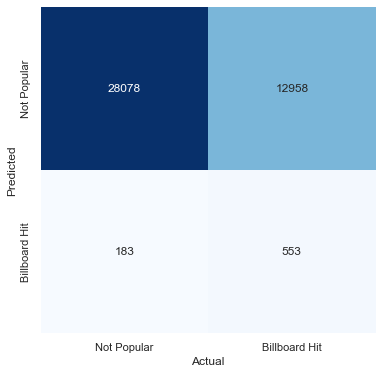

Wall time: 2min 19s


In [117]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 1000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.036047234406268155
0.0
0.04133573588086714

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.73      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.45     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


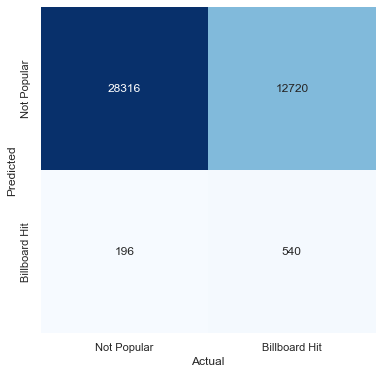

Wall time: 2min 17s


In [118]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='precision')


Crossvalidation Results
------------------------------
{'logisticregression__C': 7, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.6865216124535468
0.5
0.719398812659714

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.73      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.45     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


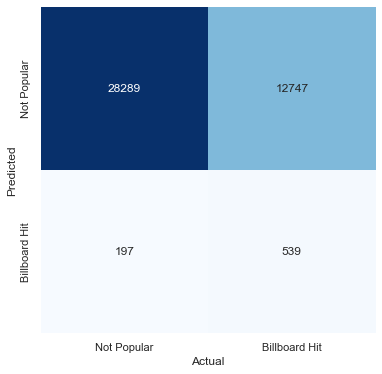

Wall time: 2min 15s


In [119]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='balanced_accuracy')


Crossvalidation Results
------------------------------
{'logisticregression__C': 5, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.06829758835589875
0.0
0.07813533772374906

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.69      0.81     41036
        True       0.04      0.72      0.08       736

    accuracy                           0.69     41772
   macro avg       0.52      0.71      0.44     41772
weighted avg       0.98      0.69      0.80     41772


Confusion Matrix
------------------------------


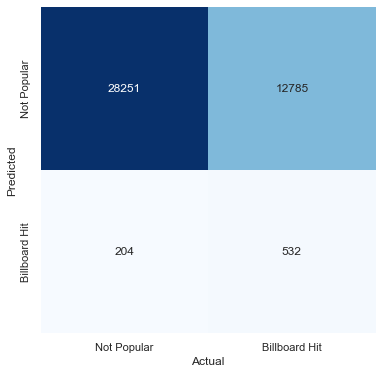

Wall time: 2min 14s


In [120]:
%%time
fit_predict_metric_model(0, dataset='Adult_Standard', n_cv=5, scoring='f1')


Crossvalidation Results
------------------------------
{'logisticregression__C': 6000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.74835640627452
0.5
0.8187039747965861

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.73      0.84    246687
        True       0.00      0.73      0.00        37

    accuracy                           0.73    246724
   macro avg       0.50      0.73      0.42    246724
weighted avg       1.00      0.73      0.84    246724


Confusion Matrix
------------------------------


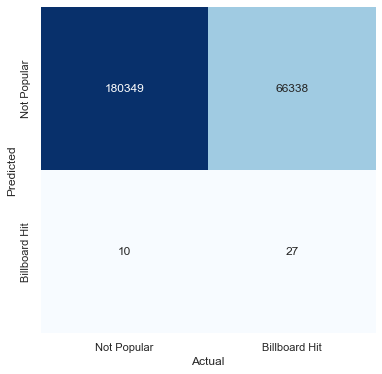

Wall time: 16min 48s


In [121]:
%%time
fit_predict_metric_model(0, dataset='cluster1_0', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 4000, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.632766477382648
0.5
0.6545887168003114

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.55      0.71    792706
        True       0.01      0.67      0.01      2932

    accuracy                           0.55    795638
   macro avg       0.50      0.61      0.36    795638
weighted avg       0.99      0.55      0.71    795638


Confusion Matrix
------------------------------


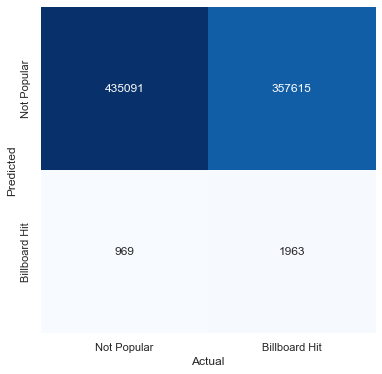

Wall time: 1h 1min 11s


In [122]:
%%time
fit_predict_metric_model(0, dataset='cluster1_1', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 10000, 'logisticregression__penalty': 'l1', 'logisticregression__solver': 'liblinear'}
0.7060791808054896
0.5
0.7409393784761877

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.65      0.79    459788
        True       0.01      0.70      0.01      1169

    accuracy                           0.65    460957
   macro avg       0.50      0.67      0.40    460957
weighted avg       1.00      0.65      0.79    460957


Confusion Matrix
------------------------------


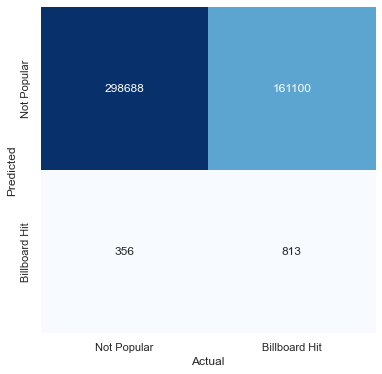

Wall time: 33min 18s


In [123]:
%%time
fit_predict_metric_model(0, dataset='cluster1_2', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'logisticregression__C': 60, 'logisticregression__penalty': 'l2', 'logisticregression__solver': 'liblinear'}
0.766248929257866
0.5
0.8201797227720171

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.72      0.84    262118
        True       0.00      0.78      0.00       108

    accuracy                           0.72    262226
   macro avg       0.50      0.75      0.42    262226
weighted avg       1.00      0.72      0.84    262226


Confusion Matrix
------------------------------


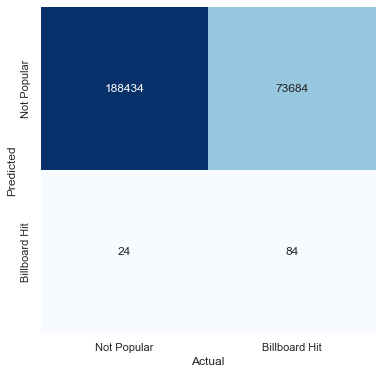

Wall time: 17min 39s


In [124]:
%%time
fit_predict_metric_model(0, dataset='cluster1_3', n_cv=5, scoring='roc_auc')

##### Other Models


Crossvalidation Results
------------------------------
{'decisiontreeclassifier__criterion': 'entropy', 'decisiontreeclassifier__max_depth': 9, 'decisiontreeclassifier__min_samples_leaf': 100}
0.7421589523074503
0.6948494134559638
0.775807957624241

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.67      0.80     41036
        True       0.04      0.73      0.07       736

    accuracy                           0.67     41772
   macro avg       0.52      0.70      0.44     41772
weighted avg       0.98      0.67      0.79     41772


Confusion Matrix
------------------------------


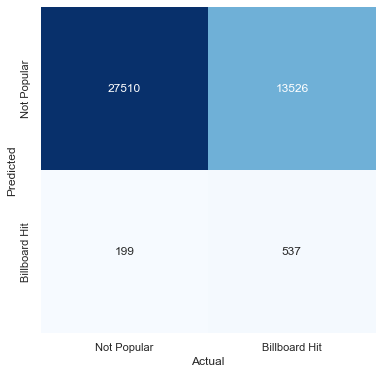

Wall time: 2min 12s


In [125]:
%%time
fit_predict_metric_model(1, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'kneighborsclassifier__metric': 'manhattan', 'kneighborsclassifier__n_neighbors': 40, 'kneighborsclassifier__weights': 'distance'}
0.7602951714362535
0.6839425877929104
0.7789305016120425

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.56      0.71     41036
        True       0.03      0.87      0.07       736

    accuracy                           0.56     41772
   macro avg       0.51      0.71      0.39     41772
weighted avg       0.98      0.56      0.70     41772


Confusion Matrix
------------------------------


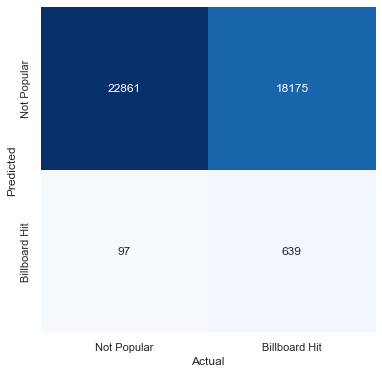

Wall time: 6min 34s


In [126]:
%%time
fit_predict_metric_model(2, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'randomforestclassifier__bootstrap': True, 'randomforestclassifier__max_depth': 50, 'randomforestclassifier__max_features': 'log2', 'randomforestclassifier__min_samples_leaf': 5, 'randomforestclassifier__n_estimators': 500}
0.7862043279548806
0.69201545563241
0.8101129095900592

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       1.00      0.66      0.80     41036
        True       0.04      0.82      0.08       736

    accuracy                           0.67     41772
   macro avg       0.52      0.74      0.44     41772
weighted avg       0.98      0.67      0.78     41772


Confusion Matrix
------------------------------


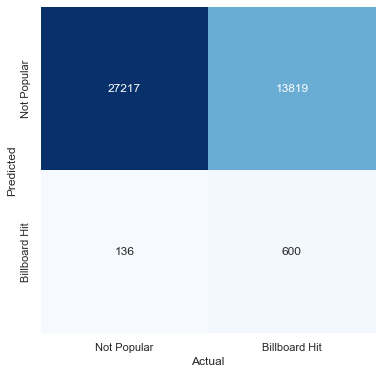

Wall time: 1h 39min 47s


In [127]:
%%time
fit_predict_metric_model(3, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')


Crossvalidation Results
------------------------------
{'adaboostclassifier__algorithm': 'SAMME.R', 'adaboostclassifier__learning_rate': 0.05, 'adaboostclassifier__n_estimators': 1000}
0.7273069539528305
0.4001997699586147
0.7970740685826228

Classification Report
------------------------------
               precision    recall  f1-score   support

       False       0.99      0.66      0.80     41036
        True       0.04      0.80      0.08       736

    accuracy                           0.67     41772
   macro avg       0.52      0.73      0.44     41772
weighted avg       0.98      0.67      0.78     41772


Confusion Matrix
------------------------------


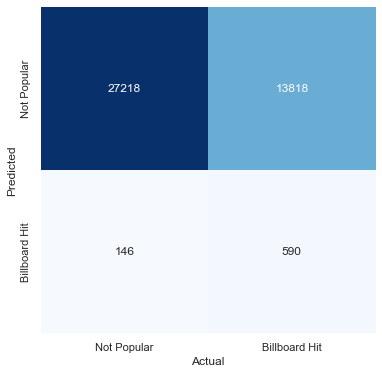

Wall time: 44min 19s


In [135]:
%%time
fit_predict_metric_model(4, dataset='Adult_Standard', n_cv=5, scoring='roc_auc')

# OLDER CODE: no meaningful results

### Which ML models did well with default settings?

In [419]:
with open('default_results.pickle', 'rb') as f:
    default_results = pickle.load(f)

In [422]:
ML_algorithms = [
    LogisticRegression,
    DecisionTreeClassifier,
    KNeighborsClassifier,
    RandomForestClassifier,
    AdaBoostClassifier
]

def default_results_by_metric(class_type='True', metric='f1-score'):
    """convert default results into readable form"""
    output_ = []

    for algo in ML_algorithms:
        algo_ = str(algo())[:-2]
        temp_ = [algo_]
        for cluster in cluster_keys:
            if class_type == 'accuracy':
                metric_ = default_results[algo_][cluster][1][class_type]
            else:
                metric_ = default_results[algo_][cluster][1][class_type][metric]
            temp_.append(metric_)
        output_.append(temp_)

    df_default_results = pd.DataFrame(output_, columns=['Model']+list(default_results['LogisticRegression'].keys()))
    df_default_results['min'] = df_default_results.iloc[:, 1:].min(axis=1)
    df_default_results['max'] = df_default_results.iloc[:, 1:].max(axis=1)
    df_default_results['mean'] = df_default_results.iloc[:, 1:].mean(axis=1)

    return df_default_results
    

In [466]:
# best performing classification by cluster = Adult_Standard (1st or 2nd for all ML models)
sortbyfeature = 'LogisticRegression'
pd.DataFrame(default_results_by_metric().iloc[:, :-3].set_index('Model').T).sort_values(sortbyfeature, ascending=False)

Model,LogisticRegression,DecisionTreeClassifier,KNeighborsClassifier,RandomForestClassifier,AdaBoostClassifier
Adult_Standard,0.077,0.060,0.065,0.080,0.077
R&B,0.072,0.063,0.065,0.081,0.076
Country,0.038,0.030,0.033,0.042,0.038
Rock,0.032,0.029,0.030,0.039,0.036
Pop,0.021,0.019,0.019,0.026,0.022
Rap,0.017,0.013,0.014,0.018,0.017
cluster2_7,0.014,0.012,0.013,0.017,0.015
cluster2_1,0.012,0.011,0.011,0.016,0.014
cluster2_5,0.011,0.010,0.010,0.014,0.012
cluster1_1,0.011,0.010,0.011,0.014,0.012


### Logistic Regression

In [542]:
# huge list of orders of magnitude for gridsearch
# formatted a bit funny to avoid rounding errors
orders_of_magnitude = []
for lst in [[int(x)/10000 for x in range(1, 11)],
            [int(x)/1000 for x in range(1, 11)],
            [int(x)/100 for x in range(1, 11)],
            [int(x)/10 for x in range(1, 11)],
            [1 * x for x in range(1, 11)],
            [10 * x for x in range(1, 11)],
            [100 * x for x in range(1, 11)],
            [1000 * x for x in range(1, 11)]]:
    orders_of_magnitude += lst

In [544]:
%%time
# LOGISTIC REGRESSION

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['logisticregression__penalty'] = ['l1', 'l2']
param_grid['logisticregression__C'] = orders_of_magnitude

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    LogisticRegression(solver='liblinear')
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
lr_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
lr_grid.fit(X_, y_)

# results
lr_grid.best_params_, lr_grid.best_score_

Wall time: 5min 3s


({'logisticregression__C': 400, 'logisticregression__penalty': 'l2'},
 0.07800708796711779)

In [553]:
# doesn't seem like tuning is doing anything
(
    lr_grid.cv_results_['mean_test_score'].mean(), 
    lr_grid.cv_results_['mean_test_score'].min(), 
    lr_grid.cv_results_['mean_test_score'].max()
)

(0.06897831928043999, 0.0, 0.07800708796711779)

In [561]:
%%time
# DECISION TREE

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['decisiontreeclassifier__max_depth'] = [3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 40, 50, 100, None]
param_grid['decisiontreeclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
param_grid['decisiontreeclassifier__criterion'] = ['gini', 'entropy']

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    DecisionTreeClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
dt_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
dt_grid.fit(X_, y_)

# results
dt_grid.best_params_, dt_grid.best_score_

Wall time: 5min 4s


({'decisiontreeclassifier__criterion': 'gini',
  'decisiontreeclassifier__max_depth': None,
  'decisiontreeclassifier__min_samples_leaf': 50},
 0.07456561474305215)

In [562]:
# tuning isn't useful here either...
(
    dt_grid.cv_results_['mean_test_score'].mean(), 
    dt_grid.cv_results_['mean_test_score'].min(), 
    dt_grid.cv_results_['mean_test_score'].max()
)

(0.06785197229329681, 0.05958234706712688, 0.07456561474305215)

In [558]:
%%time
# KNN

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['kneighborsclassifier__n_neighbors'] = [x for x in range(2,20)]+[x for x in range(20,101,5)]
param_grid['kneighborsclassifier__weights'] = ['uniform', 'distance']
param_grid['kneighborsclassifier__metric'] = ['minkowski', 'euclidean', 'manhattan']

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    KNeighborsClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
knn_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
knn_grid.fit(X_, y_)

# results
knn_grid.best_params_, knn_grid.best_score_

Wall time: 13min 6s


({'kneighborsclassifier__metric': 'manhattan',
  'kneighborsclassifier__n_neighbors': 6,
  'kneighborsclassifier__weights': 'uniform'},
 0.07027638389807941)

In [559]:
# check min mean and max
(
    knn_grid.cv_results_['mean_test_score'].mean(), 
    knn_grid.cv_results_['mean_test_score'].min(), 
    knn_grid.cv_results_['mean_test_score'].max()
)

(0.06621236939350202, 0.05683753654031316, 0.07027638389807941)

In [563]:
%%time
# random forest

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['randomforestclassifier__n_estimators'] = [5, 10, 20, 50, 100, 200, 500, 1000, 2000]
param_grid['randomforestclassifier__max_features'] = ['sqrt', 'log2']
param_grid['randomforestclassifier__max_depth'] = [3, 5, 7, 10, 15, 20, 30, 50, 100, None]
param_grid['randomforestclassifier__min_samples_leaf'] = [5, 10, 50, 100, 1000]
param_grid['randomforestclassifier__bootstrap'] = [True, False]

# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    RandomForestClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
rf_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
rf_grid.fit(X_, y_)

# results
rf_grid.best_params_, rf_grid.best_score_

Wall time: 3h 59min 43s


({'randomforestclassifier__bootstrap': False,
  'randomforestclassifier__max_depth': 30,
  'randomforestclassifier__max_features': 'sqrt',
  'randomforestclassifier__min_samples_leaf': 5,
  'randomforestclassifier__n_estimators': 1000},
 0.08028160782282248)

In [564]:
# also didn't do great...
(
    rf_grid.cv_results_['mean_test_score'].mean(), 
    rf_grid.cv_results_['mean_test_score'].min(), 
    rf_grid.cv_results_['mean_test_score'].max()
)

(0.07444941625954442, 0.0638043296032271, 0.08028160782282248)

In [ ]:
%%time
# adaboost

# choose dataset
am_testing = False  # test tuning setup with small dataset
if am_testing:
    X_, y_ = X_small, y_small
else:
    X_, y_ = clusters['Adult_Standard']  # has the best classification results from STEP 5

# params
scoring = 'f1'
param_grid = {}
param_grid['adaboostclassifier__n_estimators'] = [10, 50, 100, 200, 500, 1000, 2000, 5000, 10000]
param_grid['adaboostclassifier__n_learning_rate'] = [0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 1.0, 1.5, 2.0]
param_grid['adaboostclassifier__n_algorithm'] = ['SAMME', 'SAMME.R']
        
# pipeline
pipe = make_pipeline(
    RandomUnderSampler(sampling_strategy='majority'), 
    AdaBoostClassifier()
)

# gridsearch
cv = StratifiedKFold(n_splits=10, shuffle=True)
ab_grid = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    cv = cv,
    scoring = scoring, 
    n_jobs = -1
)

# calculate best parameters
ab_grid.fit(X_, y_)

# results
ab_grid.best_params_, ab_grid.best_score_

In [ ]:
# check min mean and max
(
    ab_grid.cv_results_['mean_test_score'].mean(), 
    ab_grid.cv_results_['mean_test_score'].min(), 
    ab_grid.cv_results_['mean_test_score'].max()
)

### Test Ensemble Methods